In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import utils
import aug_functions
import mlp_reg_aug

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
data = pd.read_csv('../data/plasticc/good_objects.csv', index_col=0)

data = data[data.detected == 1]
data.sample(10)

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
10810495,341379,60184.3701,1,52.887424,2.639425,1,3.675929,0
199481,103023,59842.1061,5,80.333519,4.517261,1,3.987288,1
6024979,190614,59854.2242,3,78.015198,1.433756,1,3.875155,0
10011539,316648,60596.0304,2,16.340792,2.632094,1,3.790512,1
7337566,232031,59839.0573,4,150.628311,2.312289,1,3.938479,1
9932210,314070,60226.3337,2,16.484089,0.957416,1,3.790512,0
7423831,234932,60525.1824,0,82.942474,3.124590,1,3.574189,1
9015885,285327,60611.0911,3,51.955624,1.231159,1,3.875155,1
1115689,36129,60181.4232,3,27.056215,3.259725,1,3.875155,0
162114,83462,60376.0781,3,37.668751,2.021547,1,3.875155,1


In [4]:
object_ids = np.unique(data.object_id)

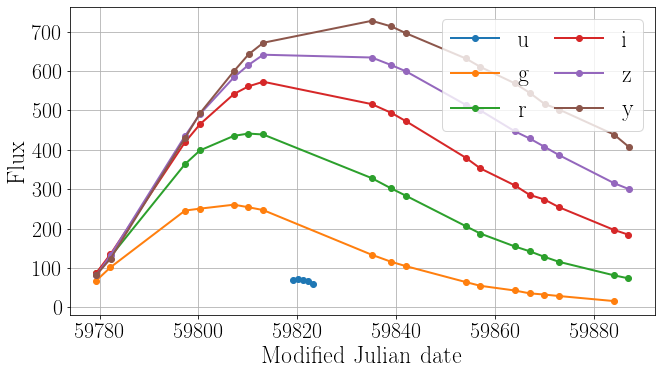

In [5]:
anobject = aug_functions.get_object(data, 34299)

aug_functions.plot_light_curves(anobject)

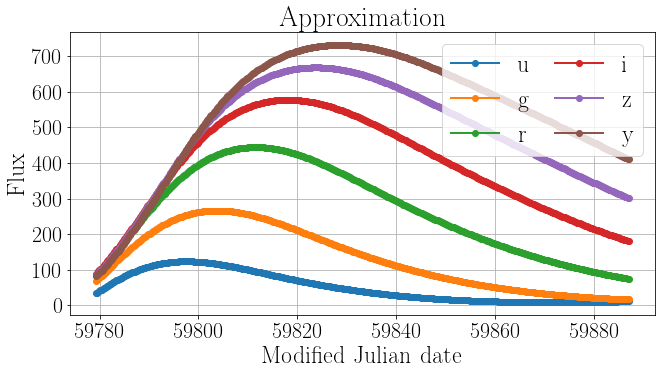

RMSE:  4.417518551589103
MAE:  3.476511669094938
RSE:  0.020999965698343778
RAE:  0.018562946543953525
MAPE:  1.9414841075715983


In [6]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
X_train_ss = ss_x.fit_transform(X_train)
X_test_ss = ss_x.transform(X_test)

ss_y = StandardScaler()
y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))
y_test_ss = ss_y.transform(y_test.reshape((-1, 1)))

from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(hidden_layer_sizes=(80,40), solver='lbfgs', activation='tanh', 
                   learning_rate_init=0.01)
reg.fit(X_train_ss, y_train_ss)

# predict flux for unseen observations
res = ss_y.inverse_transform(reg.predict(X_test_ss))
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'] = res

# predict flux for known observations
res = ss_y.inverse_transform(reg.predict(X_train_ss))
anobject_train_pred = anobject_train.copy()
anobject_train_pred['flux'] = res

approx_object = aug_functions.create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values

X_ss = ss_x.transform(X)
res = ss_y.inverse_transform(reg.predict(X_ss))
approx_object['flux'] = res
aug_functions.plot_light_curves(approx_object, "Approximation")

# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

In [8]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

def test_model(n_hidden=10, n_epochs=100, batch_size=1, lr=0.001, optimizer='sgd', activation='relu'):
    metrics = []
    index = np.random.choice(len(object_ids), size=len(object_ids) // 10)
    for i in index:
        good_id = object_ids[i]

        # get an object
        anobject = aug_functions.get_object(data, good_id)

        # train / test split
        anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

        X_train = anobject_train[['mjd', 'log_lam']].values
        X_test  = anobject_test[['mjd', 'log_lam']].values

        y_train = anobject_train['flux'].values
        y_test  = anobject_test['flux'].values

        ss = StandardScaler()
        X_train_ss = ss.fit_transform(X_train)
        X_test_ss = ss.transform(X_test)

        ss_y = StandardScaler()
        y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))

        # fit a regression model to approximate light curves
        reg = MLPRegressor(hidden_layer_sizes=(n_hidden, n_hidden//2), 
                           max_iter=n_epochs, 
                           batch_size=batch_size, 
                           learning_rate_init=lr, 
                           solver=optimizer,
                           activation=activation)
        reg.fit(X_train_ss, y_train_ss)

        # predict flux for unseen observations
        y_pred = ss_y.inverse_transform(reg.predict(X_test_ss))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        metrics.append(mape)

    return np.mean(metrics)

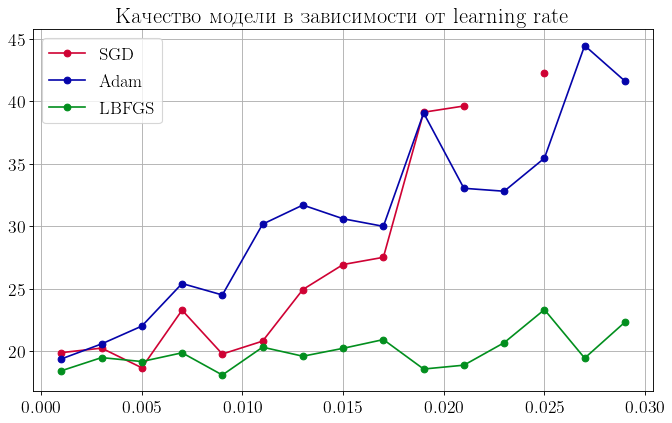

In [9]:
learning_rate = np.arange(0.001, 0.03, 0.002)
sgd_metrics = []
adam_metrics = []
lbfgs_metrics = []
sgd_lr = []
adam_lr = []
lbfgs_lr = []

for lr in tqdm_notebook(learning_rate):
    sgd_mape = test_model(n_hidden=100, optimizer='sgd', lr=lr, activation='relu')
    sgd_metrics.append(sgd_mape)
    sgd_lr.append(lr)

    adam_mape = test_model(n_hidden=100, optimizer='adam', lr=lr, activation='relu')
    adam_metrics.append(adam_mape)
    adam_lr.append(lr)
        
    lbfgs_mape = test_model(n_hidden=100, optimizer='lbfgs', lr=lr, activation='tanh')
    lbfgs_metrics.append(lbfgs_mape)
    lbfgs_lr.append(lr)

fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от learning rate", fontsize=20)
plt.plot(sgd_lr, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(adam_lr, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(lbfgs_lr, lbfgs_metrics, "-o", color="xkcd:emerald green", label="LBFGS")
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_lr_mlp.pdf")    

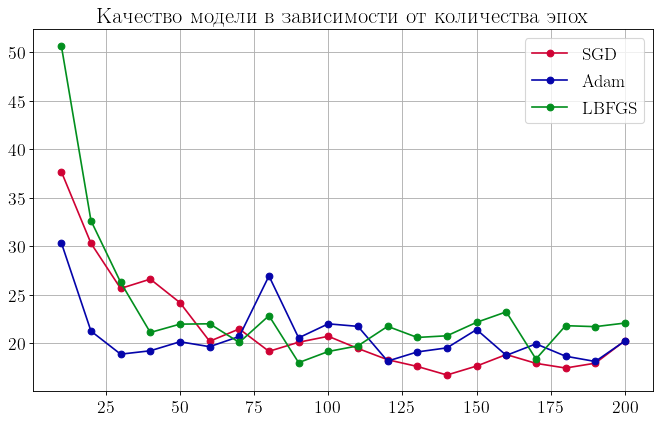

In [13]:
sgd_metrics = []
adam_metrics = []
lbfgs_metrics = []

epochs_range = np.arange(10, 201, 10)
for epochs in tqdm_notebook(epochs_range):
    adam_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='adam', activation='relu', lr=0.001)
    adam_metrics.append(adam_mape)
    sgd_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='sgd', activation='relu', lr=0.001)
    sgd_metrics.append(sgd_mape)
    lbfgs_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='lbfgs', activation='tanh', lr=0.001)
    lbfgs_metrics.append(lbfgs_mape)
    

fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества эпох", fontsize=20)
plt.grid(True)
plt.plot(epochs_range, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(epochs_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(epochs_range, lbfgs_metrics, "-o", color="xkcd:emerald green", label="LBFGS")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nepochs_mlp.pdf")

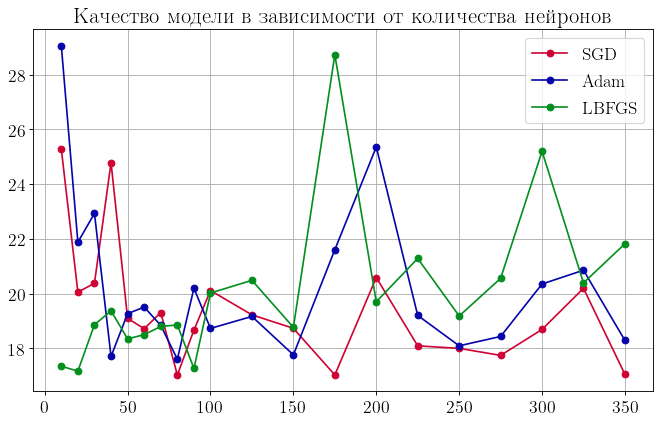

In [18]:
sgd_metrics = []
adam_metrics = []
lbfgs_metrics = []

neurons_range = np.concatenate((np.arange(10, 100, 10), np.arange(100, 351, 25)))
for n_hidden in tqdm_notebook(neurons_range):
    sgd_mape = test_model(n_hidden=n_hidden, n_epochs=140, optimizer='sgd', activation='relu', lr=0.001)
    sgd_metrics.append(sgd_mape)
    adam_mape = test_model(n_hidden=n_hidden, n_epochs=120, optimizer='adam', activation='relu', lr=0.001)
    adam_metrics.append(adam_mape)
    lbfgs_mape = test_model(n_hidden=n_hidden, n_epochs=90, optimizer='lbfgs', activation='tanh', lr=0.001)
    lbfgs_metrics.append(lbfgs_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества нейронов", fontsize=20)
plt.plot(neurons_range, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(neurons_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(neurons_range, lbfgs_metrics, "-o", color="xkcd:emerald green", label="LBFGS")
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nhidden_mlp.pdf")

In [12]:
anobject = aug_functions.get_object(data, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# fit augmentation model
model = mlp_reg_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err = model.predict(anobject_test['mjd'].values, 
                                    anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)

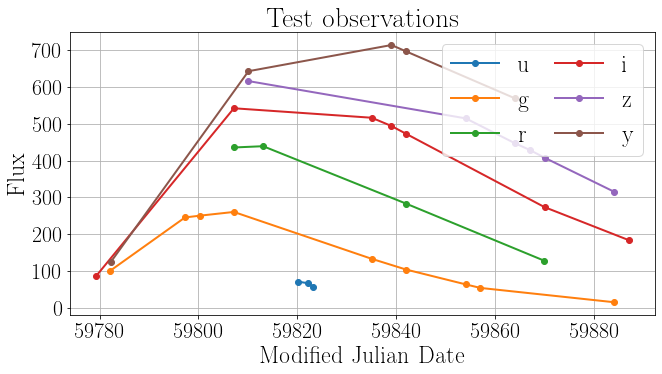

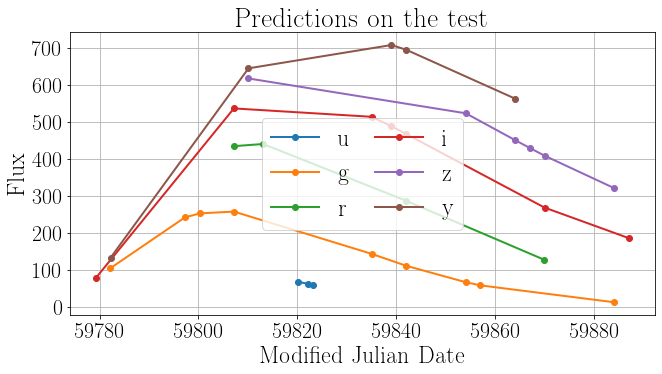

In [13]:
anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, 
                                               flux_pred, anobject_test['passband'].values)

aug_functions.plot_light_curves(anobject_test, "Test observations")
aug_functions.plot_light_curves(anobject_test_pred, "Predictions on the test")

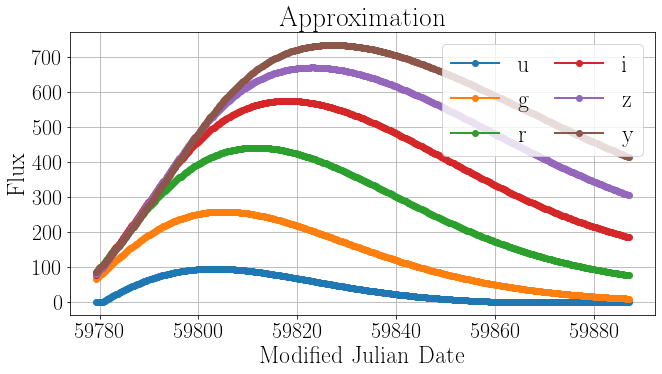

In [14]:
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, passbands_aug)
aug_functions.plot_light_curves(anobject_aug, "Approximation")

In [8]:
from tqdm import tqdm
from tqdm import tqdm_notebook

metrics = []
for good_id in tqdm_notebook(object_ids):
    # get an object
    anobject = aug_functions.get_object(data, good_id)

    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)
    
    # fit augmentation model
    model = mlp_reg_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # calc metrics
    metrics.append(utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                           flux_pred))

df_metrics = pd.DataFrame(data=metrics, columns=["RMSE", "MAE", "RSE", "RAE", "MAPE"])
df_metrics.mean()

  0%|          | 0/2508 [00:00<?, ?it/s]

RMSE    18.450351
MAE     10.323830
RSE      0.345539
RAE      0.291022
MAPE    17.181607
dtype: float64

In [13]:
rmse = np.array(metrics)[:,0]
mae = np.array(metrics)[:,1]
rse = np.array(metrics)[:,2]
rae = np.array(metrics)[:,3]
mape = np.array(metrics)[:,4]

N = len(object_ids)
assert len(rmse) == N
assert len(mae) == N
assert len(rse) == N
assert len(rae) == N
assert len(mape) == N

sample_coeffs = np.random.randint(0, N, (10000, 1000))
sample_rmse = rmse[sample_coeffs]
sample_rmse_mean = sample_rmse.mean(axis=1)
print("RMSE: mean = %.4f, std = %.4f" % (sample_rmse_mean.mean(), sample_rmse_mean.std()))
sample_mae = mae[sample_coeffs]
sample_mae_mean = sample_mae.mean(axis=1)
print("MAE:  mean = %.4f, std = %.4f" % (sample_mae_mean.mean(), sample_mae_mean.std()))
sample_rse = rse[sample_coeffs]
sample_rse_mean = sample_rse.mean(axis=1)
print("RSE:  mean = %.4f,  std = %.4f" % (sample_rse_mean.mean(), sample_rse_mean.std()))
sample_rae = rae[sample_coeffs]
sample_rae_mean = sample_rae.mean(axis=1)
print("RAE:  mean = %.4f,  std = %.4f" % (sample_rae_mean.mean(), sample_rae_mean.std()))
sample_mape = mape[sample_coeffs]
sample_mape_mean = sample_mape.mean(axis=1)
print("MAPE: mean = %.4f, std = %.4f" % (sample_mape_mean.mean(), sample_mape_mean.std()))

RMSE: mean = 18.4484, std = 6.1086
MAE:  mean = 10.3203, std = 2.6683
RSE:  mean = 0.3456,  std = 0.0089
RAE:  mean = 0.2910,  std = 0.0071
MAPE: mean = 17.1820, std = 0.4707
